In [1]:
expe_name='4-23'  #'1-22'

In [2]:
if expe_name == '4-23':
    from fit_data_4_23_common import *
    from fit_data_4_23_list_maskers import *
elif expe_name=='1-22':
    from fit_data_1_22_common import *
    from fit_data_1_22_list_maskers import *

pl.style.use('fivethirtyeight')

#mpl.rc('figure', figsize=(10,8))
mpl.rcParams['axes.facecolor']='white'  
mpl.rcParams['figure.facecolor'] = '1'

from optim import *

import os
import json

import re

reference masker power spectral density (0 attn): 40.92 dB
fitting data:
 A=0.002, alpha=-1.99, t0=0.50 ms


In [3]:
import torch.distributed as dist

### Common for all CFs

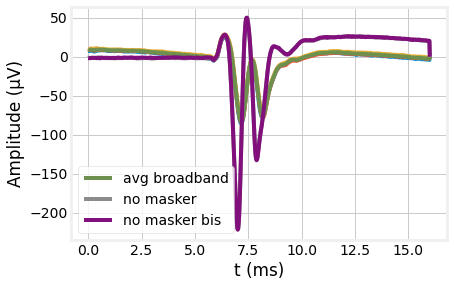

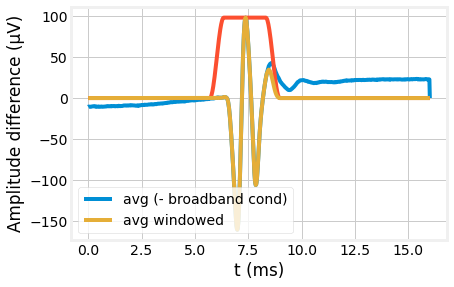

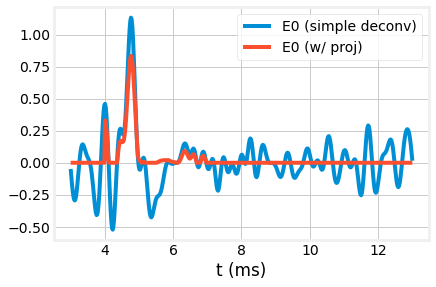

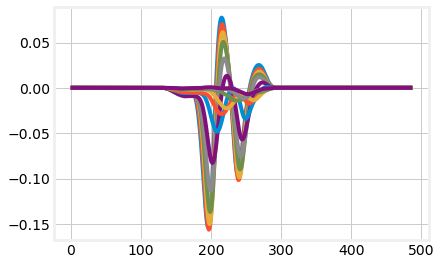

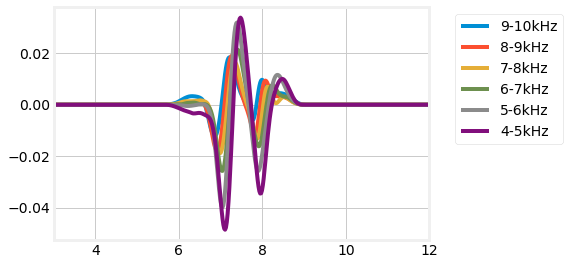

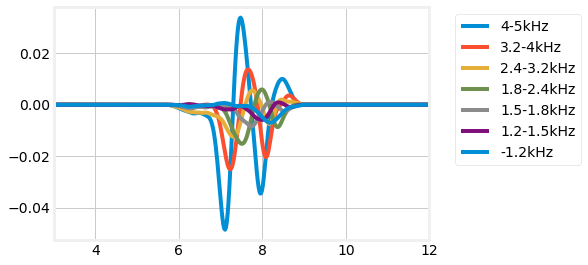

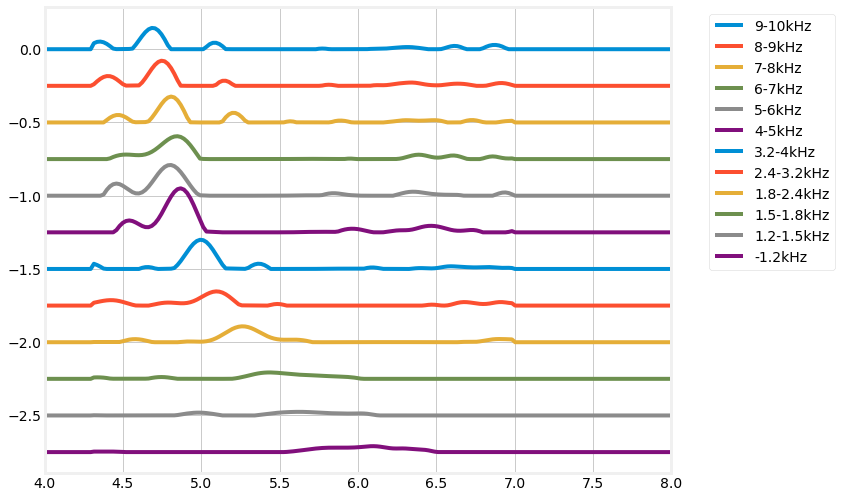

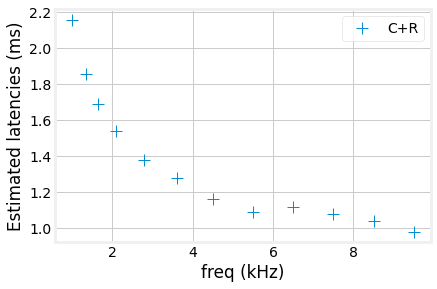

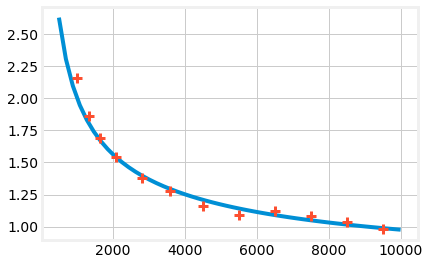

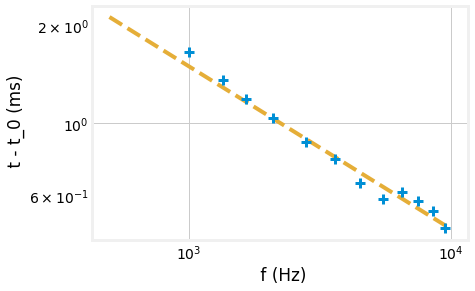

In [4]:
#see fit_data_1_22_common.py

plot_main_CAPs()
plot_CAP_with_window()



if expe_name == '1-22':
    pass
    plot_CAP_w_wo_filter()

#NB: the plots below depend on the choice of the signal used for the estimation of ur
plot_raw_excitation_deconv()
plot_figures_narrowband_analysis()
plot_figures_narrowband_analysis_deconv()
plot_estimated_latencies_deconv()
plot_latencies_fit()

### CF specific

first estimation I/O curve

In [5]:
#CF=8000
CF=8000

E0_distributed=False #if True, E0 will be estimated from the main node of a distributed scheme (external process)
#load params from E0_params.json
Q10_distributed=False #if True, Q10 will be computed and estimated from the main node of a distributed scheme
#load params from RBF_params.json

backend=dist.Backend('GLOO')
n_workers=2
rank=1

write_results=False #write ur, I/O func, Q10 in a file
if Q10_distributed:
    results_folder=f'./results/fit{expe_name}-distrib/'
else:
    results_folder=f'./results/fit{expe_name}/'
    
#to run (distributed): papermill -p E0_distributed True -p Q10_distributed True -p n_workers 5 -p rank 1 -p CF 4000 Fit\ data\ 1-22\ above\ 4kHz.ipynb fitdata4000.ipynb

In [6]:
if write_results and not(os.path.exists(results_folder)):
    os.makedirs(results_folder)

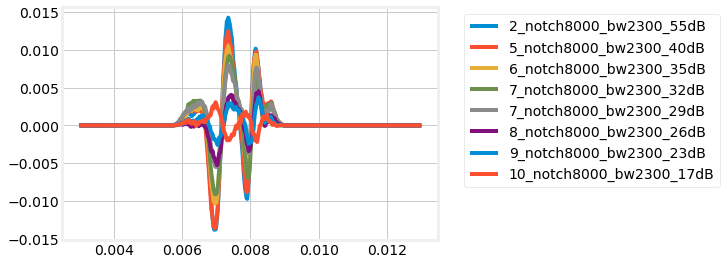

Text(0, 0.5, 'Amplitude difference')

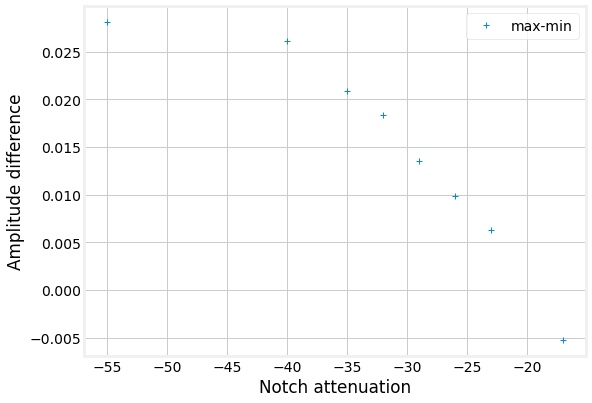

In [7]:

cap=[]
rms=[]
masker_list=ntch_masker_lists[CF]  #, 'broadband_noise' 
masker_list=[st.replace('-', '_').replace('.json', '') for st in masker_list]


reg_exp=ntch_regexps[CF]

for i, masker in enumerate(masker_list):
    sig=capData.get_signal_by_name(masker)
    if not(re.match(reg_exp, masker)):
        continue
    sig=process_signal(sig)
    broadband_sig_trunc=process_signal(broadband2)
    
    #REF broadband
    cap_amp=np.max(sig-broadband_sig_trunc)-np.min(sig-broadband_sig_trunc)
    #HACK
    if '17dB' in masker:
        cap_amp*=-1
    cap.append(cap_amp)
    #rms.append(np.std(sig-broadband_sig_trunc))
    
    #cap.append(np.max(sig)-np.min(sig))
    #rms.append(np.std(sig-broadband_sig_trunc))
    pl.plot(t2, sig-broadband_sig_trunc, label=masker)


pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
pl.show()

pl.figure(figsize=(8, 6))

if expe_name =='1-22':
    attns=-np.array([55, 50, 45,40,35,32,29,26,23])   # 20])
elif expe_name == '4-23':
    attns=-attns_arrays[CF]
pl.plot(attns, cap, '+', label='max-min')

#pl.plot(-np.array([55,50,45,40,37,34,31,28,25,22]), np.array(rms)*10, label='rms x10')
pl.legend()
pl.xlabel('Notch attenuation')
pl.ylabel('Amplitude difference')


In [8]:
len(attns)

8

In [9]:
sigm=SigmoidIOFunc(0, 0)
#maskamount=1-(  (cap-np.amin(cap)) /np.amax(cap-np.amin(cap)) )
maskamount=1-(cap/np.amax(cap)) 

I_pts=I0+attns
#sigm.fit_data(I_pts, maskamount, set_mmax=True)

#HACK enforce masking=100% at attn20
#sigm.mmax.data*=1/sigm(I0-20)

sigm.fit_data(I_pts, maskamount, constrained_at_Iref=True, Iref=I0-20)

wb_cdf=WeibullCDF_IOFunc()

wb_cdf.fit_data(I_pts, maskamount, constrained_at_Iref=True, Iref=I0-20)

if write_results:
    np.savez(f'{results_folder}/maskamountCAP_{CF}.npz', I_pts=I_pts, maskamount=maskamount)
    sigm.write_to_npz(f'{results_folder}/sigmIO_1st_estim_{CF}.npz')
    wb_cdf.write_to_npz(f'{results_folder}/wbcfdIO_1st_estim_{CF}.npz')

fitting data (constraint =1 at I=20.9dB) :
 mu=18.46, a=0.1438, mmax:1.702
fitting data:
 I0=0.59, scale=831.89, k=1.17


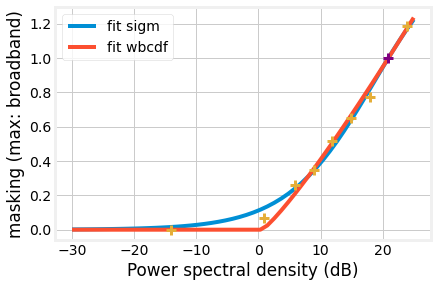

In [10]:
I=np.linspace(-30, 25)


pl.plot(I, sigm(torch.tensor(I)), label='fit sigm')
pl.plot(I, wb_cdf(torch.tensor(I)), label='fit wbcdf')
pl.xlabel('Power spectral density (dB)')

pl.plot(I_pts, maskamount, '+', markersize=10, markeredgewidth=3)

pl.plot(I0-20, 1, '+', markersize=10, markeredgewidth=3, color='purple')

pl.ylabel('masking (max: broadband)')
pl.legend()

Setting model

In [11]:

#reg_exp=ntch_regexps[CF]  #previous method

fln_list=ntch_masker_lists[CF]
masker_list=[st.replace('-', '_').replace('.json', '') for st in fln_list]
reg_exp=')|('.join(masker_list)
reg_exp='('+reg_exp+')'

ntch_maskerNames, ntch_maskingConds, ntch_signals =capData.get_batch_re(reg_exp)
ntch_maskingConds.set_amp0_dB(I0)

In [12]:
#HACK pad maskers >12e3 to avoid issues with latencies (equivalent to taking the difference
#  excitations of maskers - excitation 'broadband noise')
ntch_maskingConds.pad_maskers(f_thr=11000, f_max=1e5)
ntch_maskingConds.pad_maskers2() #same thing for low freqs

In [13]:
gauss_sigma=(1e-4)/(t2[1]-t2[0])
ntch_signals_proc=process_signal2(ntch_signals, gauss_sigma=gauss_sigma)

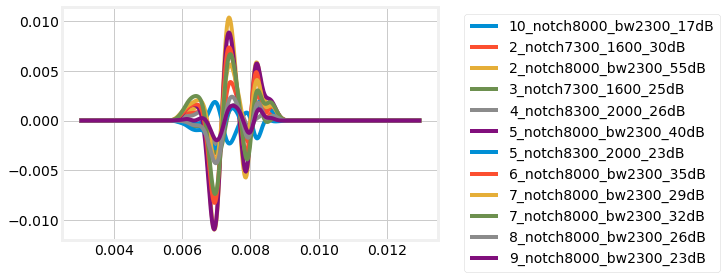

In [14]:
# test

for maskerName, sig in zip(ntch_maskerNames, ntch_signals_proc):
    pl.plot(t2, sig, label=maskerName)

pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

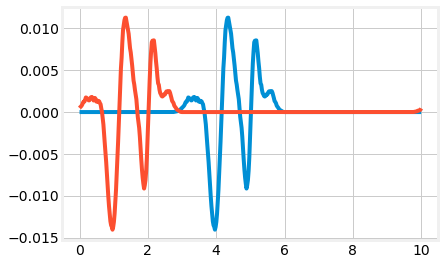

In [15]:
# estimation ur

sig=capData.get_signal_by_name('5_notch8000_bw2300_40dB')
sig2=process_signal(sig)

pl.plot((t2-3e-3)*1e3, sig2-broadband_proc)

#pl.plot(t2*1e3, sig2bis-broadband_proc)

t_shift=6e-3-3e-3 #excitation coincides with CM

ur0=sig2-broadband_proc
ur0=np.roll(ur0,  -int(t_shift*48828) )
pl.plot((t2-3e-3)*1e3, ur0)
#pl.xlim([4,6])

In [16]:
#latencies model

#lat_model=lat_above4k
#lat_model=lat

#lat_model=PowerLawLatencies.shift(lat_model, 6e-3-1e-3)   #t0: start CM-1ms

#HACK as latencies are very small (sampling issues), manual dilatation

#lat_model=lat_above4k
lat_model=lat
lat_shifted=PowerLawLatencies.shift(lat_model, 6e-3-1e-3)   #t0: start CM-1ms
lat_shifted.name='true latencies'

use_bincount=True
if use_bincount:
    lat_model=lat_shifted
else:
    #HACK as latencies are very small (sampling issues), manual dilatation
    lat_model=PowerLawLatencies.fromPts(0.0056, 10000, 0.007, 800, name= 'dilatated (hack)')
    #not required with bincount
    #lat_model=PowerLawLatencies.fromPts(0.0057, 9500, 0.0062, 6000)

In [17]:
#test single lat model
singleLat=False
if singleLat or use_bincount:
    if CF>6500:
        f_min=4000
        f_max=12000
    elif CF < 5500:
        if CF<4500:
            f_min=2000
            f_max=7500
        else:
            f_min=2200
            f_max=8000
    else:
        f_min=2500
        f_max=9000
        
    if E0_distributed:
        with open('E0_params.json') as f:
            params = json.load(f)
            f_min=float(params['f_min'])
            f_max=float(params['f_max'])
        
    if singleLat:
        lat_model = SingleLatency(6e-3, f_min=f_min, f_max=f_max)


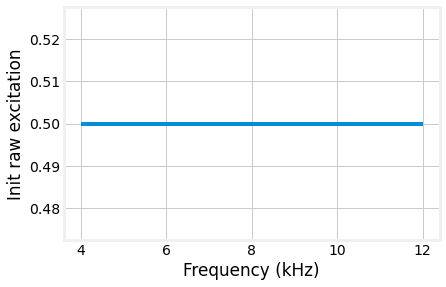

In [18]:
if singleLat or use_bincount:
    
    if E0_distributed:
        with open('E0_params.json') as f:
            params = json.load(f)
            m=int(params['m'])
    else:
        m=400
    E0=1/2*np.ones((m,))
    
    pl.plot(np.linspace(f_min*1e-3, f_max*1e-3, m), E0)
    pl.xlabel('Frequency (kHz)')
    pl.ylabel('Init raw excitation')
else:
    m=72
    E0_temp=sg.windows.tukey(m, alpha=0.5) 
    E0=np.zeros_like(t2)
    ind_begin=int((t_shift-1e-3)*48828)
    ind_end=int((t_shift-1e-3)*48828)+m
    E0[ind_begin:ind_end]=E0_temp

    pl.plot(t2*1e3, E0)
    pl.title('Init raw excitation')
    pl.xlabel('t (ms)')
    pl.ylabel('Amp')

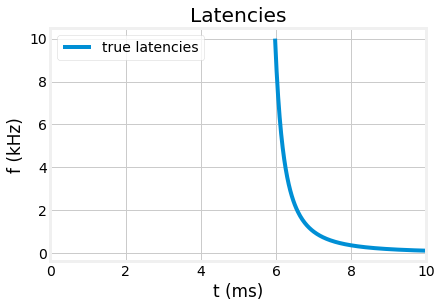

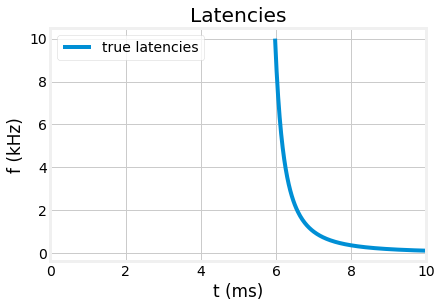

In [19]:
plotLatencies(lat_model)

In [20]:
E=ExcitationPatterns(t2, E0, use_bincount=use_bincount, bincount_fmin=f_min, bincount_fmax=f_max)  #no non-maskable part
#E=ExcitationPatterns(t2, E_temp.E0_maskable)

#NB: first model for estimation of ur, cte bandwith, fixed
if CF>4000:
    BW10_0=2000
else:
    BW10_0=1300
BW10_0Func=constant_BW10(BW10_0, requires_grad=False) 

#E.set_masking_model(lat_model, BW10_0Func, ntch_maskingConds, sigm)
E.set_masking_model(lat_model, BW10_0Func, ntch_maskingConds, wb_cdf)

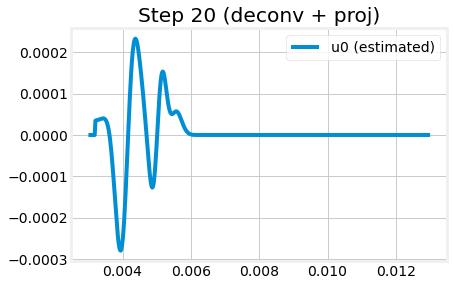

In [21]:
#estimation ur

maskAmounts, excs = E.get_tensors() 

nb_steps=20
alpha=np.linspace(0.5, 0.05, nb_steps)

EPs_fft=np.fft.rfft(excs, axis=1)
CAPs_fft=np.fft.rfft(ntch_signals_proc, axis=1)
#u1_mat=np.tile(ur0, (ntch_maskingConds.n_conditions, 1))
u1_mat=np.zeros_like(ntch_signals_proc)
filter_mat  = (t2>7.5e-3)+(t2<3.2e-3)
filter_mat=np.tile(filter_mat, (ntch_maskingConds.n_conditions, 1))
#filter_mat=np.zeros_like(ntch_signals_proc, dtype=bool)
#proj_fft=E.get_projector_fft()

weights=np.sqrt(np.sum(excs.clone().detach().numpy()**2, axis=1))
for i in range(1, nb_steps+1):
    du=deconv_newton_step(u1_mat, EPs_fft, CAPs_fft, eps_ridge=0)   #TODO proj_fft
    #du=deconv_grad(u1_mat, EPs_fft, CAPs_fft)
    
    u1_mat-=alpha[i-1]*du
    #proj 1 
    u1_mat[filter_mat]=np.zeros_like(u1_mat[filter_mat])
    #proj 2

    #u1_mat_mean=np.mean(u1_mat, axis=0)[None, :]
    
    
    #HACK waiting for proj_fft
    u1_mat_mean=np.average(u1_mat, axis=0, weights=weights)[None, :]
    u1_mat=np.repeat(u1_mat_mean, ntch_maskingConds.n_conditions, axis=0)
     
    '''
    for i in range(5):
            pl.figure()
            name=ntch_maskerNames[i]
            pl.plot(u1_mat[i], label=name, color=f'C{i}')
            #pl.plot( np.abs(EPs_fft[i]))
            pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    '''
    

    if i==nb_steps:
        pl.figure()
        pl.title(f'Step {i} (deconv + proj)')
        #pl.plot(t, u0, label='u0 (truth)')
        pl.plot(t2, u1_mat[0], label='u0 (estimated)')
        pl.legend()
        #pl.savefig('ur_8kHz_Q395.svg')
        pl.show()
        
if write_results:
    np.savez(f'{results_folder}/ur_{CF}.npz', t2=t2, ur=u1_mat[0])


Maskers and signals

In [22]:
#verious freqs. (for estimating E0)
fln_list=vfreq_fln_lists[CF]
masker_list=[st.replace('-', '_').replace('.json', '') for st in fln_list]

reg_exp=')|('.join(masker_list)
reg_exp='('+reg_exp+')'
vfreq_maskerNames, vfreq_maskingConds, vfreq_signals =capData.get_batch_re(reg_exp)
vfreq_signals_proc=process_signal2(vfreq_signals, gauss_sigma=gauss_sigma)
vfreq_maskingConds.set_amp0_dB(I0)
vfreq_maskingConds.pad_maskers(f_thr=11000, f_max=np.Inf)

#various bws (for estimating Q10)
fln_list=vbw_fln_lists[CF]
masker_list=[st.replace('-', '_').replace('.json', '') for st in fln_list]
reg_exp=')|('.join(masker_list)
reg_exp='('+reg_exp+')'
vbw_maskerNames, vbw_maskingConds, vbw_signals =capData.get_batch_re(reg_exp)
vbw_signals_proc=process_signal2(vbw_signals, gauss_sigma=gauss_sigma)
vbw_maskingConds.set_amp0_dB(I0)
#HACK
vbw_maskingConds.pad_maskers(f_thr=11000, f_max=1e5)


fine-tuning (I/O curve, Q10)

In [23]:
# try more accurate estimation of i/o curve

signals_proc=ntch_signals_proc
maskingConds=ntch_maskingConds


io_func = 'weibull' 
#io_func= 'sigm'

#sigm2=SigmoidIOFunc(sigm.mu.numpy(), sigm.a.numpy(), Iref=I0-20, constrained_at_Iref=True, requires_grad=True)


#sigm2=SigmoidIOFunc(sigm.mu.numpy(), sigm.a.numpy(), Iref=I0-20, constrained_at_Iref=True, requires_grad=True)

sigm2=SigmoidIOFunc(5., 0.25, Iref=I0-20, constrained_at_Iref=True, requires_grad=True)


# wb_cdf2=WeibullCDF_IOFunc(I0=wb_cdf.I0.numpy(),
#     scale=wb_cdf.scale.numpy(),
#     mmax=wb_cdf.mmax.numpy(),
#     k=wb_cdf.k.numpy(),
#     requires_grad=True,
#     constrained_at_Iref=True,
#     Iref=I0-20)

# wb_cdf2=WeibullCDF_IOFunc(I0=-21.,
#     scale=30.,
#     k=13.,
#     mmax=1.,
#     requires_grad=True,
#     constrained_at_Iref=True,
#     Iref=I0-20)

wb_cdf2=WeibullCDF_IOFunc(I0=-24.,
    scale=30.,
    k=5.5,
    mmax=1.,
    requires_grad=True,
    constrained_at_Iref=True,
    Iref=I0-20)

#E2=ExcitationPatterns(t2, E0, requires_grad=True)  #no non-maskable part
E2=ExcitationPatterns.copyRaw(E, requires_grad=True)
if Q10_distributed or E0_distributed:   
    #init group
    if not(dist.is_initialized()):
        dist.init_process_group(backend, init_method='tcp://127.0.0.1:1234', world_size=n_workers, rank=rank)  
    
    if Q10_distributed:
        Q10rbf=Q10RBFNet.create_from_jsonfile('RBF_params.json')
        #update weights (has to be sent by main process)
        Q10rbf.update_weights()
        BW10_0TestFunc=Q10RBFNet_BW10(Q10rbf)
    #Not needed to load weights for E0 as should be initialized at 1 anyway
    
    
else:
    BW10_0TestFunc=constant_BW10(2000., requires_grad=True)


In [24]:
#optim params

alpha=30
alpha_Q10=3e7


#for estimation of E0
n_dim=4 #projection of gradient on n_dim first harmomics (Fourier basis)


if io_func=='weibull':
    #alpha_dic={wb_cdf2.I0: 30*alpha, wb_cdf2.scale: 5*alpha, wb_cdf2.k: 30*alpha}
    alpha_dic={wb_cdf2.I0: 10*alpha, wb_cdf2.scale: alpha, wb_cdf2.k: 10*alpha}
    
    #alpha_dic={wb_cdf2.I0: 0.1*alpha, wb_cdf2.scale: 0.05*alpha, wb_cdf2.k: 0.6*alpha}
else:
    alpha_dic={sigm2.mu: 0.01*alpha, sigm2.a: 0.005*alpha}

#alpha_dic[BW10_0TestFunc.BW_10]=alpha
#alpha_dic[E2.E0_maskable]=0.1*alpha  #/!| with sum_grad_E0 set to True #previous method to modify E0 amp
alpha_dic[E2.E0_maskable_amp]=0.1*alpha  


alpha_dic_Q10={}

if Q10_distributed:
    alpha_dic_Q10[BW10_0TestFunc.Q10RBFnet.l2.weight]=0.05*alpha
else:
    alpha_dic_Q10[BW10_0TestFunc.BW_10]=alpha_Q10 #cte bw
    


alpha_dic_E0={E2.E0_maskable: 0.2*alpha}


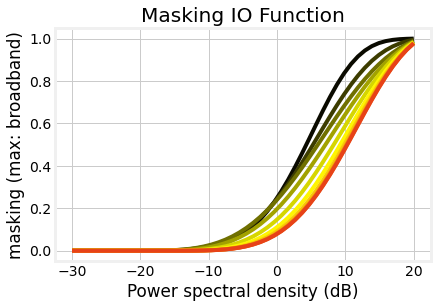

In [25]:
#first optim I/O func

nb_stepsIO=50

if io_func=='weibull':
    E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, wb_cdf2)
else:
    E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, sigm2)

axes, ind_plots=optim_steps(E2, u1_mat[0], signals_proc, alpha_dic, 
            nb_steps=nb_stepsIO, #sum_grad_E0=True, 
                            plot_masking_I0_graph=True,
           step_plots=5)


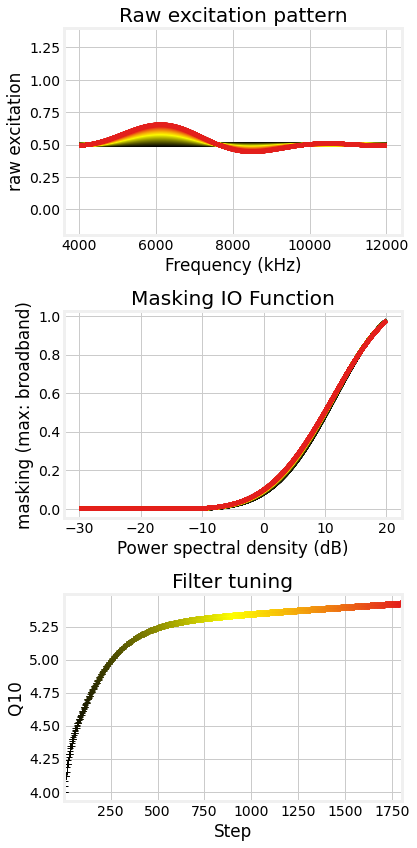

In [26]:
#note change params for I/O func
#TODO write in json?
alpha_dic[wb_cdf2.I0]=0.5*alpha
alpha_dic[wb_cdf2.scale]= 0.05*alpha
alpha_dic[wb_cdf2.k]= 0.5*alpha    

n_it=200  #100
nb_steps=3 #5
tot_steps=3*n_it*nb_steps


pl.figure(figsize=(6, 12))

for i in range(n_it):
    
    if E0_distributed:  #update E0
        dist.recv(E2.E0_maskable, src=0, tag=8)
    if Q10_distributed:
        Q10rbf.update_weights()
       
    #E0
    if io_func=='weibull':
        E2.set_masking_model(lat_model, BW10_0TestFunc, vfreq_maskingConds, wb_cdf2)
    else:
        E2.set_masking_model(lat_model, BW10_0TestFunc, vfreq_maskingConds, sigm2)

    if i==0:
        axes, ind_plots=optim_steps(E2, u1_mat[0], vfreq_signals_proc, alpha_dic_E0, 
            nb_steps=nb_steps, 
            n_dim_E0=n_dim,      
            E0_distributed=E0_distributed,
             #E0_t_min=t_min_E0, E0_t_max=t_max_E0, k_mode_E0=k_mode_E0,
            plot_E0_graph=True, plot_masking_I0_graph=True,
            plot_Q10=True, fc_ref_Q10=CF,
           step_plots=5, tot_steps=tot_steps)  #init graphs
    else:
        axes, ind_plots=optim_steps(E2, u1_mat[0], vfreq_signals_proc, alpha_dic_E0, 
            nb_steps=nb_steps, 
            n_dim_E0=n_dim, 
            E0_distributed=E0_distributed,                        
             #E0_t_min=t_min_E0, E0_t_max=t_max_E0, k_mode_E0=k_mode_E0,
            plot_E0_graph=True, plot_masking_I0_graph=True,
            plot_Q10=True, fc_ref_Q10=CF, step_plots=5, axes=axes, ind_plots=ind_plots, 
            step0=(3*i)*nb_steps, tot_steps=tot_steps) 

    #I/O Func (+ amp E0)
    if io_func=='weibull':
        E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, wb_cdf2)
    else:
        E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, sigm2)
    
    axes, ind_plots=optim_steps(E2, u1_mat[0], signals_proc, alpha_dic, 
                nb_steps=nb_steps, #sum_grad_E0=True, 
                plot_E0_graph=True, plot_masking_I0_graph=True,
                plot_Q10=True, fc_ref_Q10=CF,
               step_plots=5, axes=axes, ind_plots=ind_plots, step0=(3*i+1)*nb_steps,
                 tot_steps=tot_steps)

#     #Q10
    
    if io_func=='weibull':
        E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, wb_cdf2)
    else:
        E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, sigm)

    optim_steps(E2, u1_mat[0], vbw_signals_proc, alpha_dic_Q10, 
            nb_steps=nb_steps, sum_grad_E0=True, 
            plot_E0_graph=True, plot_masking_I0_graph=True,
            plot_Q10=True, fc_ref_Q10=CF,
           step_plots=5, axes=axes, ind_plots=ind_plots, step0=(3*i+2)*nb_steps,
               tot_steps=tot_steps, #verbose=i%5,
               Q10_distributed=Q10_distributed)

pl.tight_layout()

In [27]:
#write data
if write_results:
    if io_func=='weibull':
        
        wb_cdf2.write_to_npz(f'{results_folder}/wbcfdIO_{CF}.npz')
    else:
        sigm2.write_to_npz(f'{results_folder}/sigmIO_{CF}.npz')
    
    
    
    if isinstance(lat_model, SingleLatency):
        np.savez(f'{results_folder}/E0_{CF}.npz', f=lat_model.get_f_linspace(len(t2)).detach().numpy(),
                E0=E2.E0_maskable.detach().numpy())
    #TODO bincount mode, use E.bincount_f
    
    if Q10_distributed:
        pass

    Q10optim= CF/E2.bw10Func(torch.tensor(CF, dtype=torch.float32))
    np.save(f'{results_folder}/Q10optim_{CF}.npy',
            Q10optim.detach().numpy() )
    
    
    #write params
    
    json_data={}
    json_data["n_it"]=n_it
    json_data["nb_steps"]=nb_steps
    json_data["tot_steps"]=tot_steps

    alpha=30
    alpha_Q10=3e7


    #for estimation of E0
    json_data["n_dim"]=n_dim 

    if io_func=='weibull':
        json_data_alpha={"I0": alpha_dic[wb_cdf2.I0], "scale": alpha_dic[wb_cdf2.scale],
                         "k": alpha_dic[wb_cdf2.k]}
    else:
        json_data_alpha={"mu": alpha_dic[sigm2.mu], "a": alpha_dic[sigm2.a]}

        
    #json_data_alpha["E0_amp"]=alpha_dic[E2.E0_maskable] #previous method
    json_data_alpha["E0_amp"]=alpha_dic[E2.E0_maskable_amp]

    
    json_data["Q10_distributed"]=Q10_distributed
    
    if Q10_distributed:
        json_data_alpha["Q10RBFweights"]=alpha_dic_Q10[BW10_0TestFunc.Q10RBFnet.l2.weight]
    else:
        json_data_alpha["Q10"]= alpha_dic_Q10[BW10_0TestFunc.BW_10] #cte bw



    json_data_alpha["E0"]=alpha_dic_E0[E2.E0_maskable]
    
    json_data["alpha"]=json_data_alpha
    
    
    with open(f'{results_folder}/optim_params_{CF}.txt', 'w') as outfile:
        json.dump(json_data, outfile, indent=4)


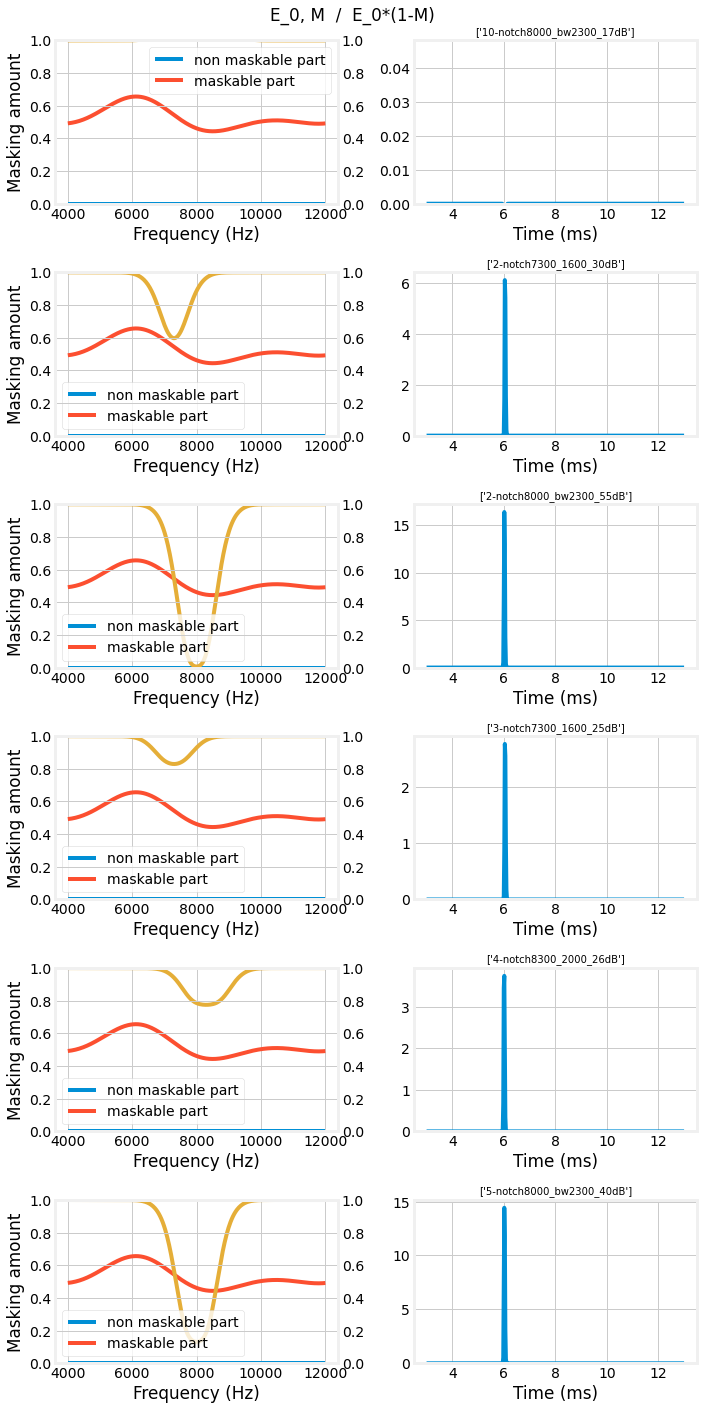

In [28]:
with torch.no_grad():
    #various notch atten
    if io_func=='weibull':
        E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, wb_cdf2)
    else:
        E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, sigm2)
    
    #various notch widths
    
#     if io_func=='weibull':
#         E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, wb_cdf2)
#     else:
#         E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, sigm2)

    pl.figure(figsize=(10,20))
    plotExcitationPatterns(E2, plot_raw_excitation=True) # ylim_top=1
    pl.show()

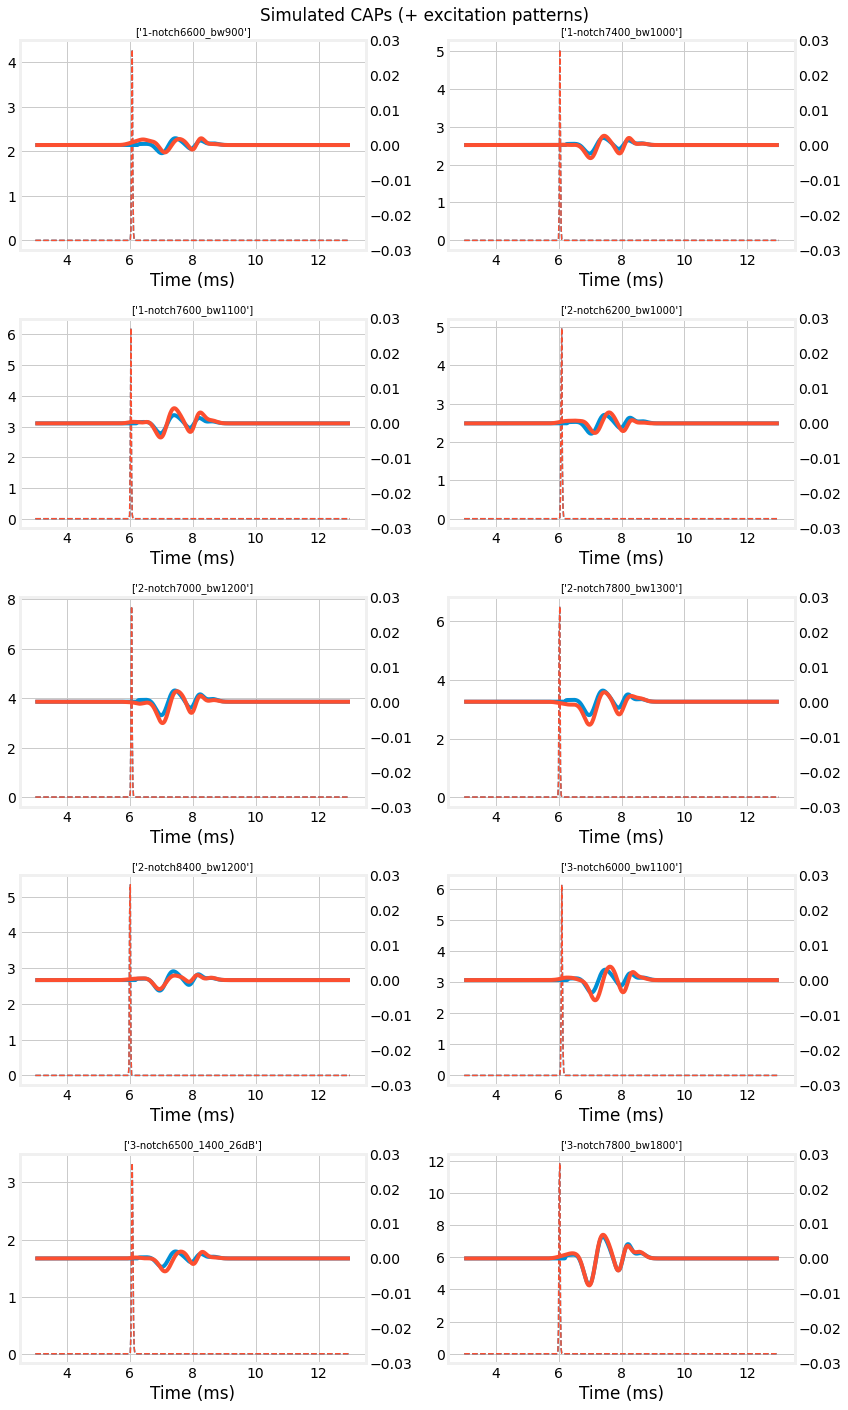

In [29]:
#model
with torch.no_grad():
    if io_func=='weibull':
        E2.set_masking_model(lat_model, BW10_0TestFunc, vfreq_maskingConds, wb_cdf2)
    else:
        E2.set_masking_model(lat_model, BW10_0TestFunc, vfreq_maskingConds, sigm2)
    
    u1=u1_mat[0]
    pl.figure(figsize=(12,20))
    ax_list=plotSimulatedCAPs(E2, u1, ylim=[-0.03, 0.03], max_plots=10)
    plotSimulatedCAPs(E2, CAParray=vfreq_signals_proc, axlist=ax_list, max_plots=10)
    pl.plot()

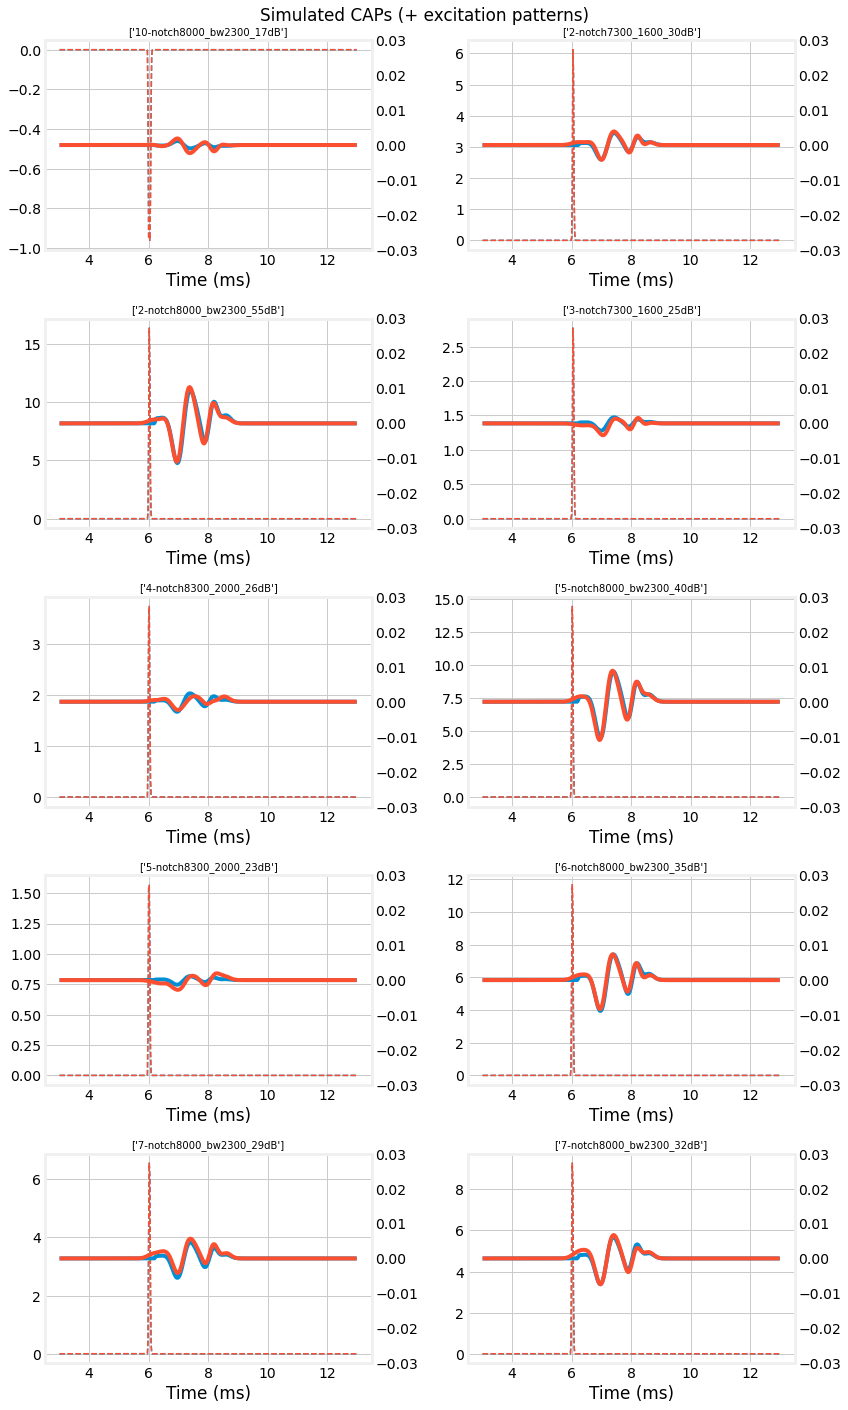

In [30]:
#model
with torch.no_grad():
    if io_func=='weibull':
        E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, wb_cdf2)
    else:
        E2.set_masking_model(lat_model, BW10_0TestFunc, ntch_maskingConds, sigm2)
    
    u1=u1_mat[0]
    pl.figure(figsize=(12,20))
    ax_list=plotSimulatedCAPs(E2, u1, ylim=[-0.03, 0.03], max_plots=10)
    plotSimulatedCAPs(E2, CAParray=ntch_signals_proc, axlist=ax_list, max_plots=10)
    pl.plot()

[]

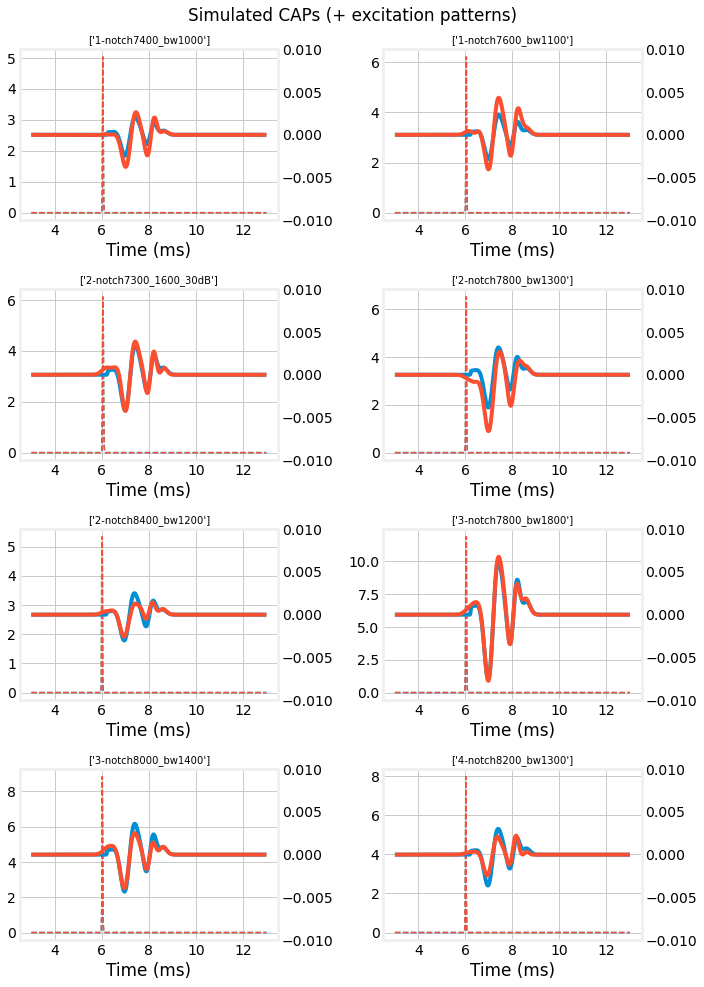

In [31]:
#model
u1=u1_mat[0]
pl.figure(figsize=(10,14))
if io_func=='weibull':
    E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, wb_cdf2)
else:
    E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, sigm2)
    
    
with torch.no_grad():
    ax_list=plotSimulatedCAPs(E2, u1, ylim=[-0.01, 0.01])
    plotSimulatedCAPs(E2, CAParray=vbw_signals_proc, axlist=ax_list)
pl.plot()

estimated bw10: 1464 Hz


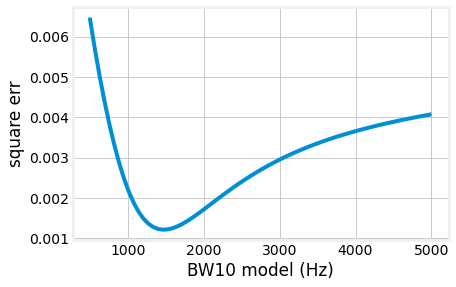

In [32]:
bw_arr=np.linspace(500, 5000, num= ((4000-500)//50+1) )
sigs_ref=vbw_signals_proc
errs=[]
for bw in bw_arr:

    BW10_0TestFunc=constant_BW10(bw, requires_grad=False)


    if io_func=='weibull':
        E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, wb_cdf2)
    else:
        E2.set_masking_model(lat_model, BW10_0TestFunc, vbw_maskingConds, sigm2)
    excs = E2.get_tensor() 
    maskingConditions = E2.maskingConditions
    err=0
    for i, exc in zip(range(maskingConditions.n_conditions), excs):
        exc_np = exc.detach().numpy()
        CAP=np.convolve(exc_np, u1, mode='full')
        t=E.t.numpy()
        CAP=CAP[0:len(E2.t)]
        err+=np.sum( (CAP-sigs_ref[i])**2)
    errs.append(err)
    
pl.plot(bw_arr, errs)
pl.xlabel('BW10 model (Hz)')

pl.ylabel('square err')


ind_min=np.argmin(errs)
print(f'estimated bw10: {bw_arr[ind_min]:.0f} Hz')

if write_results:
    np.savez(f'{results_folder}/Q10gridsearch_{CF}.npz', bw=bw_arr, bw10_est=bw_arr[ind_min])